In [ ]:
!pip install biopython
# !pip install -r requirements.txt

import sys
import os
import logging
import yaml
import torch
from google.colab import drive
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import random

drive.mount('/content/drive')

PROJECT_DIR = "/content/drive/MyDrive/BiologicalData/progetto/biological_data_pfp/biological_data_pfp"
SRC_DIR = f"{PROJECT_DIR}/src"
CONFIG_FILE = f"{PROJECT_DIR}/notebooks/flavio/config.yaml"
OUTPUT_FILE = f"{PROJECT_DIR}/results/submission.tsv"

sys.path.append(SRC_DIR)

# Choose device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

# Load the configuration data from the YAML file
with open(CONFIG_FILE, 'r') as f:
    config_data = yaml.safe_load(f)

import data_preprocessing as dp

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda


In [ ]:
train_set, train_sequences, train_ids, train_embeddings, train_domains = dp.load_train_data(config_data)

In [ ]:
del train_sequences
del train_domains
del train_embeddings

In [ ]:
#train_set = dp.add_sequence_length(train_sequences, train_set)
#train_set = dp.add_domain(train_domains, train_set)
train_mf, train_bp, train_cc = dp.split_by_aspect(train_set)

In [ ]:
del train_set

In [ ]:
# Summary statistics
# Get number of examples
n_train = len(train_set)
n_train_mf = len(train_mf)
n_train_bp = len(train_bp)
n_train_cc = len(train_cc)

# Header
line = "#" * 27
text = "#   SUMMARY STATISTICS    #"
print(f"       {line}")
print(f"       {text}")
print(f"       {line}")
print(f">>>>>>>>> FULL TRAINING DATASET <<<<<<<<<")
print(f"  |--- N rows: {n_train}")
print(f"  |--- Proteins (unique): {len(train_ids)}")
print(f"  |--- GO terms (unique): {len(train_set['go_term'].unique())}")
print(f"  |--- Domains")
print(f"      |--- Unique: {len(train_domains['ipr_id'].unique())}")
#print(f"      |--- Proteins with NaN domain: {len(train_ids) - len(train_domains['protein_id'].unique())}")
print("=" * 41)
print(f">>>>>>>>> SPLIT TRAINING DATASET <<<<<<<<")
print(f"  |--- N rows (total): {n_train_mf + n_train_bp + n_train_cc}")
print(f"  |--- Biological process (BP)")
print(f"      |--- N rows: {n_train_bp} ({n_train_bp/n_train*100:.3f}%)")
print(f"      |--- Proteins (unique): {len(train_bp['protein_id'].unique())}")
print(f"      |--- GO terms (unique): {len(train_bp['go_term'].unique())}")
print(f"      |--- Domains")
#print(f"          |--- Unique: {train_bp['domains'].apply(tuple).nunique()}")
#print(f"          |--- Proteins with NaN domain: {len(train_bp['protein_id'].unique()) - len(train_bp['protein_id'].unique())}")
print(f"  |--- Cellular component (CC)")
print(f"      |--- N rows: {n_train_cc} ({n_train_cc/n_train*100:.3f}%)")
print(f"      |--- Proteins (unique): {len(train_cc['protein_id'].unique())}")
print(f"      |--- GO terms (unique): {len(train_cc['go_term'].unique())}")
print(f"      |--- Domains")
#print(f"          |--- Unique: {train_cc['domains'].apply(tuple).nunique()}")
#print(f"          |--- Proteins with NaN domain: {len(train_cc['protein_id'].unique()) - len(train_cc['protein_id'].unique())}")
print(f"  |--- Molecular function (MF)")
print(f"      |--- N rows: {n_train_mf} ({n_train_mf/n_train*100:.3f}%)")
print(f"      |--- Proteins (unique): {len(train_mf['protein_id'].unique())}")
print(f"      |--- GO terms (unique): {len(train_mf['go_term'].unique())}")
print(f"      |--- Domains")
#print(f"          |--- Unique: {train_mf['domains'].apply(tuple).nunique()}")
#print(f"          |--- Proteins with NaN domain: {len(train_mf['protein_id'].unique()) - len(train_mf['protein_id'].unique())}")

       ###########################
       #   SUMMARY STATISTICS    #
       ###########################
>>>>>>>>> FULL TRAINING DATASET <<<<<<<<<
  |--- N rows: 4277047
  |--- Proteins (unique): 50128
  |--- GO terms (unique): 3004
  |--- Domains
      |--- Unique: 27090
>>>>>>>>> SPLIT TRAINING DATASET <<<<<<<<
  |--- N rows (total): 4277047
  |--- Biological process (BP)
      |--- N rows: 2634883 (61.605%)
      |--- Proteins (unique): 83064
      |--- GO terms (unique): 1487
      |--- Domains
  |--- Cellular component (CC)
      |--- N rows: 1109632 (25.944%)
      |--- Proteins (unique): 84638
      |--- GO terms (unique): 678
      |--- Domains
  |--- Molecular function (MF)
      |--- N rows: 532532 (12.451%)
      |--- Proteins (unique): 55698
      |--- GO terms (unique): 839
      |--- Domains


Import train and test set

In [ ]:
df_train_mf = pd.read_csv("{}/train/blast_dfs/df_blast_mf_train_tfidf.tsv".format(PROJECT_DIR), sep='\t', index_col=0)
df_train_cc = pd.read_csv("{}/train/blast_dfs/df_blast_cc_train_tfidf.tsv".format(PROJECT_DIR), sep='\t', index_col=0)
df_train_bp = pd.read_csv("{}/train/blast_dfs/df_blast_bp_train_tfidf.tsv".format(PROJECT_DIR), sep='\t', index_col=0)

df_test_mf = pd.read_csv("{}/train/blast_dfs/df_blast_mf_test_tfidf.tsv".format(PROJECT_DIR), sep='\t', index_col=0)
df_test_cc = pd.read_csv("{}/train/blast_dfs/df_blast_cc_test_tfidf.tsv".format(PROJECT_DIR), sep='\t', index_col=0)
df_test_bp = pd.read_csv("{}/train/blast_dfs/df_blast_bp_test_tfidf.tsv".format(PROJECT_DIR), sep='\t', index_col=0)


get labels for classification

In [ ]:
def get_y_bin(data):
    y = data.groupby('protein_id')['go_term'].apply(list).to_dict()
    mlb = MultiLabelBinarizer()
    y_bin = mlb.fit_transform(y.values())
    y_bin_df = pd.DataFrame(y_bin, index=y.keys(), columns=mlb.classes_)
    return y_bin, y_bin_df, mlb

train_mf = train_mf[train_mf['protein_id'].isin(df_train_mf.index)]
train_bp = train_bp[train_bp['protein_id'].isin(df_train_bp.index)]
train_cc = train_cc[train_cc['protein_id'].isin(df_train_cc.index)]

y_bin_mf, y_bin_df_mf, mlb_mf = get_y_bin(train_mf)
y_bin_bp, y_bin_df_bp, mlb_bp = get_y_bin(train_bp)
y_bin_cc, y_bin_df_cc, mlb_cc = get_y_bin(train_cc)

assert all(y_bin_df_mf.index == df_train_mf.index), "y_bin_mf is not aligned with df_train_mf!"
assert all(y_bin_df_bp.index == df_train_bp.index), "y_bin_bp is not aligned with df_train_bp!"
assert all(y_bin_df_cc.index == df_train_cc.index), "y_bin_cc is not aligned with df_train_cc!"

print(y_bin_df_mf.shape)
print(y_bin_df_bp.shape)
print(y_bin_df_cc.shape)

(55251, 839)
(82389, 1487)
(83948, 678)


In [ ]:
del train_mf
del train_bp
del train_cc

split train and validation

In [ ]:
def train_val_split(df, y_bin, v_size=0.2):
    # Only split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        df,            # Your embeddings
        y_bin,         # Your multi-label targets
        test_size=v_size,  # Fraction of data to reserve for validation
        random_state=42,  # Ensures reproducibility
    )
    return X_train, X_val, y_train, y_val

X_train_mf, X_val_mf, y_train_mf, y_val_mf = train_val_split(df_train_mf, y_bin_mf)
del df_train_mf
del y_bin_mf
X_train_bp, X_val_bp, y_train_bp, y_val_bp = train_val_split(df_train_bp, y_bin_bp)
del df_train_bp
del y_bin_bp
X_train_cc, X_val_cc, y_train_cc, y_val_cc = train_val_split(df_train_cc, y_bin_cc)
del df_train_cc
del y_bin_cc

In [ ]:
print(X_train_mf.shape)
print(X_val_mf.shape)
print(y_train_mf.shape)
print(y_val_mf.shape)


(44200, 1863)
(11051, 1863)
(44200, 839)
(11051, 839)


define model

In [ ]:
# DNN builder
def build_model(output_dim, input_dim):
    model = Sequential()
    model.add(Dense(512, input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_dim, activation='sigmoid'))  # Output for multi-label classification
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc", multi_label=True)  # Multi-label AUC
        ]
    )
    return model

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot auc
    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], label='Train Auc')
    plt.plot(history.history['val_auc'], label='Validation Auc')
    plt.title('Auc Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Auc')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def train_model(X_train, y_train, X_val, y_val, epochs, batch_size):
    output_dim = y_train.shape[1]  # Number of output labels
    input_dim = X_train.shape[1]  # Dimensionality of input features
    model = build_model(input_dim=input_dim, output_dim=output_dim)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Plot training and validation metrics
    plot_metrics(history)
    return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - auc: 0.6264 - binary_accuracy: 0.9751 - loss: 0.0745 - precision: 0.3321 - recall: 0.3205 - val_auc: 0.9008 - val_binary_accuracy: 0.9930 - val_loss: 0.0239 - val_precision: 0.7682 - val_recall: 0.5559 - learning_rate: 0.0010
Epoch 2/30
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - auc: 0.8614 - binary_accuracy: 0.9929 - loss: 0.0244 - precision: 0.8057 - recall: 0.4911 - val_auc: 0.9152 - val_binary_accuracy: 0.9934 - val_loss: 0.0217 - val_precision: 0.7792 - val_recall: 0.5890 - learning_rate: 0.0010
Epoch 3/30
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.8842 - binary_accuracy: 0.9932 - loss: 0.0227 - precision: 0.8068 - recall: 0.5221 - val_auc: 0.9172 - val_binary_accuracy: 0.9934 - val_loss: 0.0211 - val_precision: 0.7757 - val_recall: 0.6026 - learning_rate: 0.0010
Epoch 4/30
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - auc: 0.8937 - binary_accuracy: 0.9933 - loss: 0.0217 - precision: 0.8082 - recall: 0.5411 - val

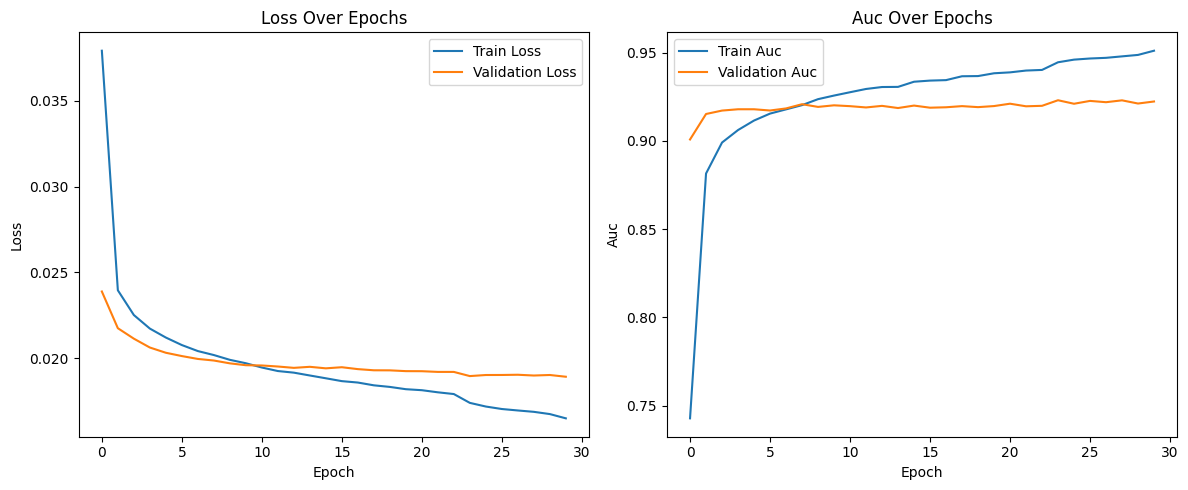

In [ ]:
EPOCHS = 30
BACTH_SIZE = 32

model_mf = train_model(X_train_mf, y_train_mf, X_val_mf, y_val_mf, EPOCHS, BACTH_SIZE)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 34s 12ms/step - auc: 0.6512 - binary_accuracy: 0.9710 - loss: 0.0993 - precision: 0.3601 - recall: 0.1267 - val_auc: 0.8358 - val_binary_accuracy: 0.9812 - val_loss: 0.0655 - val_precision: 0.6724 - val_recall: 0.2102 - learning_rate: 0.0010
Epoch 2/30
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - auc: 0.7936 - binary_accuracy: 0.9807 - loss: 0.0668 - precision: 0.6898 - recall: 0.1815 - val_auc: 0.8457 - val_binary_accuracy: 0.9814 - val_loss: 0.0632 - val_precision: 0.6719 - val_recall: 0.2328 - learning_rate: 0.0010
Epoch 3/30
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - auc: 0.8118 - binary_accuracy: 0.9810 - loss: 0.0649 - precision: 0.6911 - recall: 0.1992 - val_auc: 0.8484 - val_binary_accuracy: 0.9815 - val_loss: 0.0618 - val_precision: 0.6787 - val_recall: 0.2379 - learning_rate: 0.0010
Epoch 4/30
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - auc: 0.8219 - binary_accuracy: 0.9811 - loss: 0.0638 - precision: 0.6932 - recall: 0.2075 - va

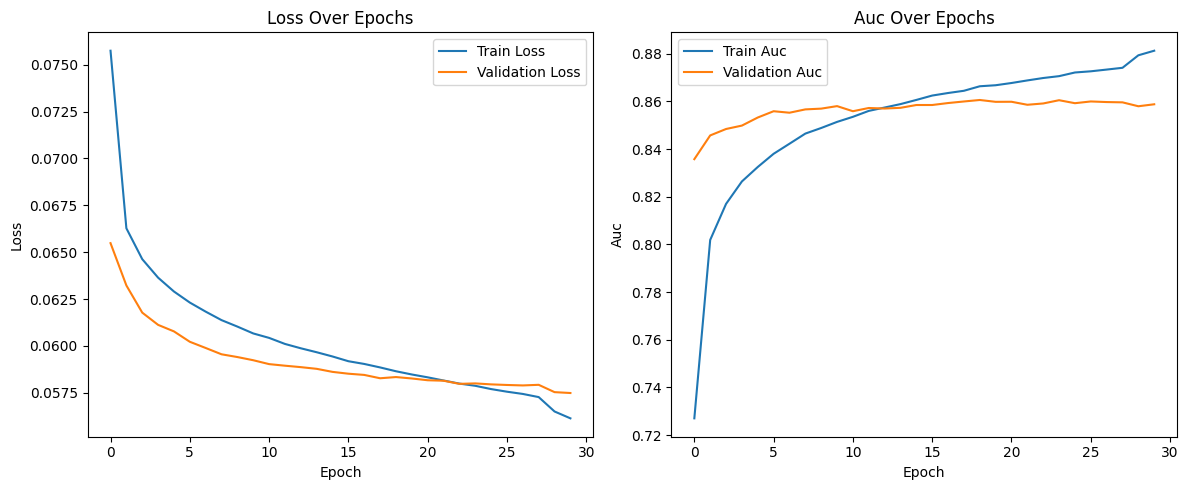

In [ ]:
model_bp = train_model(X_train_bp, y_train_bp, X_val_bp, y_val_bp, EPOCHS, BACTH_SIZE)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - auc: 0.6267 - binary_accuracy: 0.9760 - loss: 0.0702 - precision: 0.5439 - recall: 0.4712 - val_auc: 0.8608 - val_binary_accuracy: 0.9887 - val_loss: 0.0351 - val_precision: 0.7976 - val_recall: 0.5642 - learning_rate: 0.0010
Epoch 2/30
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc: 0.8095 - binary_accuracy: 0.9886 - loss: 0.0360 - precision: 0.8087 - recall: 0.5327 - val_auc: 0.8729 - val_binary_accuracy: 0.9890 - val_loss: 0.0335 - val_precision: 0.8067 - val_recall: 0.5713 - learning_rate: 0.0010
Epoch 3/30
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc: 0.8364 - binary_accuracy: 0.9888 - loss: 0.0347 - precision: 0.8115 - recall: 0.5451 - val_auc: 0.8819 - val_binary_accuracy: 0.9891 - val_loss: 0.0328 - val_precision: 0.8059 - val_recall: 0.5781 - learning_rate: 0.0010
Epoch 4/30
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - auc: 0.8504 - binary_accuracy: 0.9890 - loss: 0.0337 - precision: 0.8144 - recall: 0.5532 - val

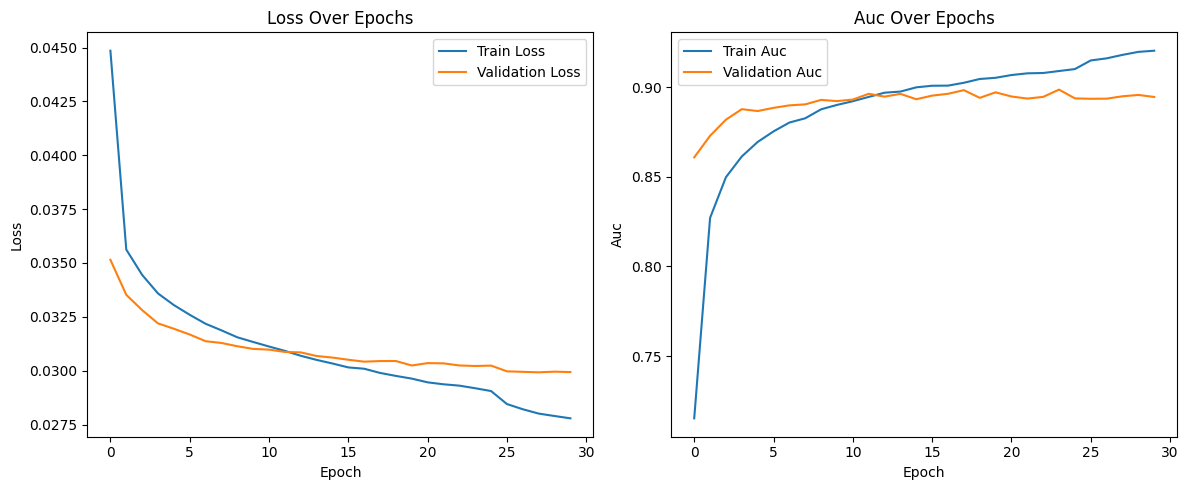

In [ ]:
model_cc = train_model(X_train_cc, y_train_cc, X_val_cc, y_val_cc, EPOCHS, BACTH_SIZE)

In [ ]:
!mkdir -p saved_model
model_mf.save('saved_model/model_mf_blast_tfidf.keras')
model_bp.save('saved_model/model_bp_blast_tfidf.keras')
model_cc.save('saved_model/model_cc_blast_tfidf.keras')

!cp -r "saved_model" "$PROJECT_DIR/notebooks/flavio"

In [ ]:
del X_train_mf
del X_val_mf
del y_train_mf
del y_val_mf
del X_train_bp
del X_val_bp
del y_train_bp
del y_val_bp
del X_train_cc
del X_val_cc
del y_train_cc
del y_val_cc

In [ ]:
test_predictions_mf = model_mf.predict(df_test_mf)
test_predictions_bp = model_bp.predict(df_test_bp)
test_predictions_cc = model_cc.predict(df_test_cc)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [ ]:
test_predictions_mf

array([[1.25261899e-12, 5.35412391e-06, 4.46189301e-11, ...,
        1.84157674e-04, 4.64092225e-01, 1.17153032e-02],
       [7.40068597e-13, 2.50120031e-08, 6.57777869e-12, ...,
        1.12916838e-04, 1.55545877e-05, 4.10871515e-08],
       [1.43441845e-08, 1.57498021e-03, 1.06256648e-09, ...,
        1.53323170e-04, 2.69456510e-03, 1.28685599e-04],
       ...,
       [1.37393916e-12, 4.00953135e-03, 5.43215126e-11, ...,
        9.03212858e-05, 2.98916902e-02, 6.54493866e-04],
       [3.33174229e-22, 2.10153477e-08, 1.39831164e-16, ...,
        2.35990797e-07, 9.20273304e-01, 1.14463884e-02],
       [4.80076245e-08, 6.91708736e-03, 1.91722123e-04, ...,
        4.92153267e-05, 1.43140564e-02, 1.69737567e-03]], dtype=float32)

In [ ]:
def collect_predictions(test_ids, test_predictions, mlb, threshold=0.1):
    test_protein_ids_list = []
    test_go_terms_list = []
    test_preds_list = []

    for protein_id, prediction in zip(test_ids, test_predictions):
        for go_term, prob in zip(mlb.classes_, prediction):
            if prob > threshold:  # Adjust threshold as needed
                test_protein_ids_list.append(protein_id)
                test_go_terms_list.append(go_term)
                test_preds_list.append(round(prob, 3))

    # Create a DataFrame for the predictions
    test_results_df = pd.DataFrame({
        'protein_id': test_protein_ids_list,
        'go_term': test_go_terms_list,
        'probability': test_preds_list
    })

    return test_results_df

In [ ]:
test_results_mf = collect_predictions(df_test_mf.index, test_predictions_mf, mlb_mf)
test_results_bp = collect_predictions(df_test_bp.index, test_predictions_bp, mlb_bp)
test_results_cc = collect_predictions(df_test_cc.index, test_predictions_cc, mlb_cc)

In [ ]:
test_results_mf

,protein_id,go_term,probability
0,G3X9G7,GO:0000976,0.342
1,G3X9G7,GO:0000977,0.207
2,G3X9G7,GO:0000981,0.298
3,G3X9G7,GO:0000987,0.132
4,G3X9G7,GO:0001067,0.343
...,...,...,...
14682,Q05946,GO:0008092,0.227
14683,Q05946,GO:0044877,0.258
14684,Q05946,GO:0051015,0.129
14685,Q05946,GO:0097159,0.507


In [ ]:
print(test_results_mf.shape)
print(test_results_bp.shape)
print(test_results_cc.shape)

(14687, 3)
(61480, 3)
(21520, 3)


In [ ]:
all_test_results = pd.concat([test_results_mf, test_results_bp, test_results_cc], axis=0)
all_test_results = all_test_results.sort_values(by=['protein_id', 'probability'], ascending=[True, False])
# TODO -> filter if there are more than 1500 values for single proteins

In [ ]:
all_test_results

,protein_id,go_term,probability
14342,A0A060W1Y7,GO:0003674,1.000
60187,A0A060W1Y7,GO:0008150,1.000
21038,A0A060W1Y7,GO:0005575,1.000
21063,A0A060W1Y7,GO:0110165,0.999
14343,A0A060W1Y7,GO:0003824,0.984
...,...,...,...
12707,X2JEE0,GO:0031410,0.106
12713,X2JEE0,GO:0097708,0.106
35446,X2JEE0,GO:0048583,0.105
35449,X2JEE0,GO:0048869,0.105


In [ ]:
filename = 'all_test_results_blast_tfidf.tsv'

all_test_results.to_csv(filename, sep='\t', index=False, header = False)

In [ ]:
pip install cafaeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 6.5 MB/s eta 0:00:00


In [ ]:
!mkdir predictions
!mv 'all_test_results_blast_tfidf.tsv' predictions/

In [ ]:
test_ground_truth_df = pd.read_csv("{}/train/tsvs/train_set.tsv".format(PROJECT_DIR), sep='\t', header=None)
test_ground_truth_df = test_ground_truth_df[test_ground_truth_df[0].isin(df_test_mf.index)]
test_ground_truth_df = test_ground_truth_df.drop([1], axis=1)
test_ground_truth_df.to_csv('test_ground_truth.tsv', sep='\t', index=False, header = False)

In [ ]:
test_ground_truth_df

,0,2
1183,E9Q7M2,GO:0008150
1184,E9Q7M2,GO:0006950
1185,E9Q7M2,GO:0006970
1186,E9Q7M2,GO:0050896
1187,E9Q7M2,GO:0009628
...,...,...
4263680,Q8R2D2,GO:0007600
4263681,Q8R2D2,GO:0008150
4263682,Q8R2D2,GO:0003008
4263683,Q8R2D2,GO:0032501


In [ ]:
!mkdir -p ground_truth
!mv test_ground_truth.tsv ground_truth

In [ ]:
import cafaeval
from cafaeval.evaluation import cafa_eval, write_results
res = cafa_eval("{}/train/go-basic.obo".format(PROJECT_DIR), "predictions/" , "ground_truth/test_ground_truth.tsv")
write_results(*res)

In [ ]:
!cp -r "results" "$PROJECT_DIR/notebooks/flavio"